In [1]:
# Import Library and System Setting
from tensorflow import keras
from shutil import copyfile,rmtree
import tensorflow as tf
import os,random
from tensorflow.keras import layers
from tensorflow.keras import activations

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_VISIBLE_DEVICES"] = '0'   #指定第一块GPU可用 -1表示用CPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.compat.v1.Session(config = config)


In [2]:
# Split the test-data and train-data
def split_data(source, test_dir, train_dir, ratio):
    files = []

    for filename in os.listdir(source):
        file = os.path.join(source,filename)
        if os.path.getsize(file)<=0:
            print(file,'is zero length. Igonred!')
        else:
            files.append(filename)
        
    train_len = int(len(files)*ratio)
    test_len = len(files)-train_len
    shuffle_set = random.sample(files,len(files))
    train_set = shuffle_set[:train_len]
    test_set = shuffle_set[-test_len:]

    print(train_len,test_len)

    if os.path.isdir(train_dir): rmtree(train_dir)
    if os.path.isdir(test_dir): rmtree(test_dir)
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    for filename in train_set:
        copyfile(os.path.join(source,filename),os.path.join(train_dir,filename))
    for filename in test_set:
        copyfile(os.path.join(source,filename),os.path.join(test_dir,filename))

    print(test_dir,'has',len(os.listdir(test_dir)),'pictures.')
    print(train_dir,'has',len(os.listdir(train_dir)),'pictures.')

working_dir_abspath = os.getcwd()
pircture_source = os.path.join(working_dir_abspath,'Cat-or-Dog')
picture_cat_source = os.path.join(pircture_source,'Cat')
picture_dog_source = os.path.join(pircture_source,'Dog')
cat_train_dir,cat_test_dir = os.path.join(pircture_source,'trian','Cat'),os.path.join(pircture_source,'test','Cat')
dog_train_dir,dog_test_dir = os.path.join(pircture_source,'trian','Dog'),os.path.join(pircture_source,'test','Dog')

train_data_ratio = 0.9
# split_data(picture_cat_source,cat_train_dir,cat_test_dir,train_data_ratio) # 重新下载数据或多次训练时打乱数据
# split_data(picture_dog_source,dog_train_dir,dog_test_dir,train_data_ratio)


In [6]:
# Model
# processing data
train_datagen, test_datagen = ImageDataGenerator(rescale=1/255),ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(os.path.join(pircture_source,'trian'),target_size=(150,150),batch_size=10,class_mode='binary') # batch_size = 100
test_generator = test_datagen.flow_from_directory(os.path.join(pircture_source,'test'),target_size=(150,150),batch_size=10,class_mode='binary') # batch_size = 100


model = keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3),activation = 'relu', input_shape = (150,150,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32,(3,3),activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),    
    keras.layers.Conv2D(16,(3,3),activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
]) # suggest 16,32,62,512

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


result = model.fit_generator(train_generator, epochs = 10, verbose = 1, validation_data = test_generator)

Found 2500 images belonging to 2 classes.
Found 22498 images belonging to 2 classes.
Epoch 1/10
250/250 [==============================] - 61s 243ms/step - loss: 0.7008 - acc: 0.5556 - val_loss: 0.6653 - val_acc: 0.5997
Epoch 2/10
250/250 [==============================] - 64s 255ms/step - loss: 0.6243 - acc: 0.6632 - val_loss: 0.6400 - val_acc: 0.6293
Epoch 3/10
250/250 [==============================] - 65s 261ms/step - loss: 0.5692 - acc: 0.7148 - val_loss: 0.5760 - val_acc: 0.7055
Epoch 4/10
250/250 [==============================] - 74s 297ms/step - loss: 0.5086 - acc: 0.7472 - val_loss: 0.5645 - val_acc: 0.7146
Epoch 5/10
250/250 [==============================] - 175s 699ms/step - loss: 0.4520 - acc: 0.7848 - val_loss: 0.5582 - val_acc: 0.7299
Epoch 6/10
250/250 [==============================] - 83s 333ms/step - loss: 0.3856 - acc: 0.8296 - val_loss: 0.6468 - val_acc: 0.6856
Epoch 7/10
250/250 [==============================] - 62s 246ms/step - loss: 0.3157 - acc: 0.8664 - val_

<Figure size 432x288 with 0 Axes>

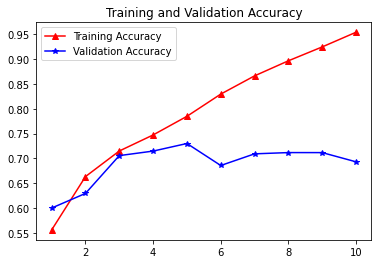

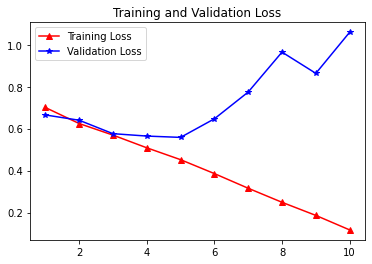

<Figure size 432x288 with 0 Axes>

In [7]:
loss,acc,val_loss,val_acc = result.history.values()
epochs = range(1,len(loss)+1)
import matplotlib.pyplot as plt
# Plot graph
plt.plot(epochs,acc,'r-^',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b-*', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r-^',label='Training Loss',color = 'red')
plt.plot(epochs,val_loss,'b-*',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [8]:
# Apply model into another picture

import numpy as np
from tensorflow.keras.preprocessing import image

# path = os.path.join(cat_test_dir,'15.jpg') # cat
path = os.path.join(dog_test_dir,'16.jpg') # dog

image = np.vstack([np.expand_dims(image.img_to_array(image.load_img(path,target_size=(150,150))),axis = 0)])

classes = model.predict(image, batch_size = 100)

print(classes[0])
if classes[0]>0.5: print("It is a dog.")
else: print("It is a cat.")

[1.]
It is a dog.
